# Приоритизация гипотез и анализ результатов А/В-теста

## Описание проекта

### Цель исследования

Приотизировать гипотезы для увеличения выручки интернет-магазина с применением фреймворков ICE и RICE, запустить и проанализировать результаты А/В-теста.

### Описание данных

**Файл с перечнем гипотез с оценками по параметрам RICE:**

`Hypothesis` — краткое описание гипотезы;

`Reach` — охват пользователей по 10-балльной шкале;

`Impact` — влияние на пользователей по 10-балльной шкале;

`Confidence` — уверенность в гипотезе по 10-балльной шкале;

`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

**Сведения о заказах в интернет магазине:**

`transactionId` — идентификатор заказа;

`visitorId` — идентификатор пользователя, совершившего заказ;

`date` — дата, когда был совершён заказ;

`revenue` — выручка заказа;

`group` — группа A/B-теста, в которую попал заказ.

**Данные по А/В-тесту:**

`date` — дата;

`group` — группа A/B-теста;

`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

### Ход исследования

1. Приоритизация гипотез с применением фреймворков ICE и RICE.

2. Выполнение анализа результатов A/B-теста:                 
- построить графики кумулятивной выручки, кумулятивного среднего чека и кумулятивной конверсии по группам, относительного изменения кумулятивного среднего чека и кумулятивной конверсии группы B к группе А;
- выбрать границы для определения аномальных пользователей и аномальных заказов путём построения точечных графиков и рассчёта 95-ого и 99-ого перцентилей;
- посчитать статистическую значимость различий в конверсии и среднем чеке между группами по "сырым" и "очищенным данным";
- принять обоснованное решение по результатам теста.

## Приоритизация гипотез

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from scipy import stats as st
pd.set_option('display.max_colwidth', -1)
import warnings

warnings.filterwarnings("ignore")

/tmp/ipykernel_63/2675629291.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В датасете представленно 9 гипотез с оценками по параметрам для приоритизации с использованием фреймворков ICE и RICE.
Названия столбцов выглядят как-то не по-питоновски, исправим это.

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

### Приоритизация фреймворком ICE

In [5]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)

In [6]:
hypothesis.sort_values(by='ice', ascending=False) #гипотезы отсортированные по снижению приоритетности (ICE)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


При оценке приоритетности гипотез с применением фреймворка ICE, наиболее приоритетной оказась 8-я гипотеза - "Запустить акцию, дающую скидку на товар в день рождения".

### Приоритизация фреймворком RICE

In [7]:
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)

In [8]:
hypothesis.sort_values(by='rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


По результатам приоритизация с изпользованием фреймворка RICE, самой приоритетной (с существенным отрывом от ближайшего преследователя) стала гипотеза номер 7 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Её показатели влияния и надежности ниже чем у 8-й гипотезы, однако 7-я гипотеза обладает самым высоким показателем охвата, что и делает её самой приоритетной при оценке фреймворком RICE.

### Промежуточный вывод

Мы провели приоритизацию гипотез фреймворками ICE и RICE:
- по результатам приоритизации фреймворком ICE наиболее приоритетной стала 8-я гипотеза;
- по результатам приоритизации фреймворком RICE наиболее приоритетной стала 7-я гипотеза, что связано с высоким показателем охвата у данной гипотезы.

## Анализ А/В-теста

Вначале проверим всё-ли впорядке с данными. Для этого создадим небольшую функцию.

In [9]:
def information(df):
    display(df.dtypes)
    print('\033[1m' + 'Первые 2 строки:' + '\033[0m')
    display(df.head(2))
    print('\033[1m' + 'Количество дубликатов:' + '\033[0m', df.duplicated().sum())
    print('\033[1m' + 'Количество пропусков:' + '\033[0m')  
    print(df.isna().sum())
    print('\033[1m' + 'Доля пропусков:' + '\033[0m')
    print(df.isna().sum() / len(df.index))

In [10]:
information(orders)

transactionId    int64 
visitorId        int64 
date             object
revenue          int64 
group            object
dtype: object

Первые 2 строки:


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B


Количество дубликатов: 0
Количество пропусков:
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
Доля пропусков:
transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64


In [11]:
information(visitors)

date        object
group       object
visitors    int64 
dtype: object

Первые 2 строки:


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619


Количество дубликатов: 0
Количество пропусков:
date        0
group       0
visitors    0
dtype: int64
Доля пропусков:
date        0.0
group       0.0
visitors    0.0
dtype: float64


С данными всё хорошо, только в датафрейме orders название двух столбцов не соответствует принятому в Python стилю, и формат в столбце с датой следует поменять на datetime.

In [12]:
orders = orders.rename(columns={'transactionId' : 'transaction_id', 'visitorId' : 'visitor_id'}) #смена названий столбцов

In [13]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')) #замена формата на datetime

In [14]:
print('Группы в А/В-тесте:', orders['group'].unique())
print('Дата начала  теста:', orders['date'].dt.date.min())
print('Дата окончания теста:', orders['date'].dt.date.max())
print('Количество пользователей в группе A:', len(orders.query('group == "A"').groupby('visitor_id')))
print('Количество пользователей в группе В:', len(orders.query('group == "B"').groupby('visitor_id')))
print('Количество совпадающих пользователей:', len(orders.groupby('visitor_id').agg({'group': 'nunique'}
                                                                                   ).reset_index().query('group > 1')))

Группы в А/В-тесте: ['B' 'A']
Дата начала  теста: 2019-08-01
Дата окончания теста: 2019-08-31
Количество пользователей в группе A: 503
Количество пользователей в группе В: 586
Количество совпадающих пользователей: 58


### Кумулятивная выручка по группам

In [16]:
dates_groups = orders[['date', 'group']].drop_duplicates() #создание массива пар уникальных значений "дата-группа"

In [17]:
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), 
    axis=1).sort_values(by=['date','group']) #получение агрегированных кумулятивных данных о заказах по дням

In [18]:
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(
    by=['date','group']) #получение агрегированных кумулятивных данных о посетителях по дням 

In [19]:
cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']) #объединение таблиц с агрегированными данными
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors'] 
#переименование столбцов в полученной таблице

In [20]:
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [21]:
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]
#получение таблиц с кумулятивным количеством заказов и кумулятивной выручкой в группах А и В

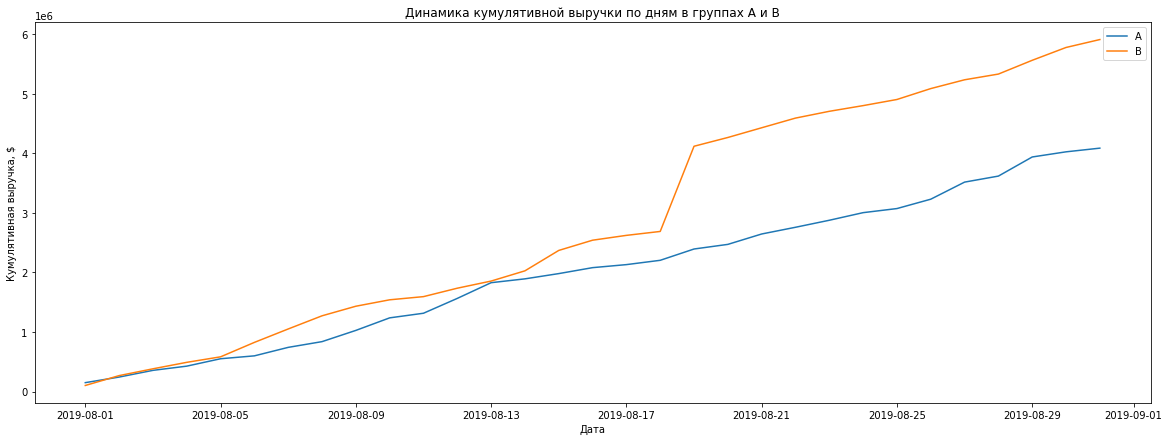

In [22]:
#построение графиков кумулятивной выручки по группам
plt.figure(figsize=(20, 7))
plt.title('Динамика кумулятивной выручки по дням в группах А и В')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка, $')
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')
plt.legend()
plt.show()

Из графиков, отражающих динамику кумулятивной выручки в группах А и В видно, что кумулятивная выручка в обоих группах растёт в течение всего периода наблюдения. Средняя кумулятивная выручка в группе В выше, чем в группе А и с течением времени эта разница нарастает. На графике кумулятивной выручки в группе В выделяется резкий рост показателя после 17.08.2019, что может свидетельствовать об аномальном увеличении количества заказов, или о появлении аномально дорогих заказов.

### Кумулятивный средний чек по группам

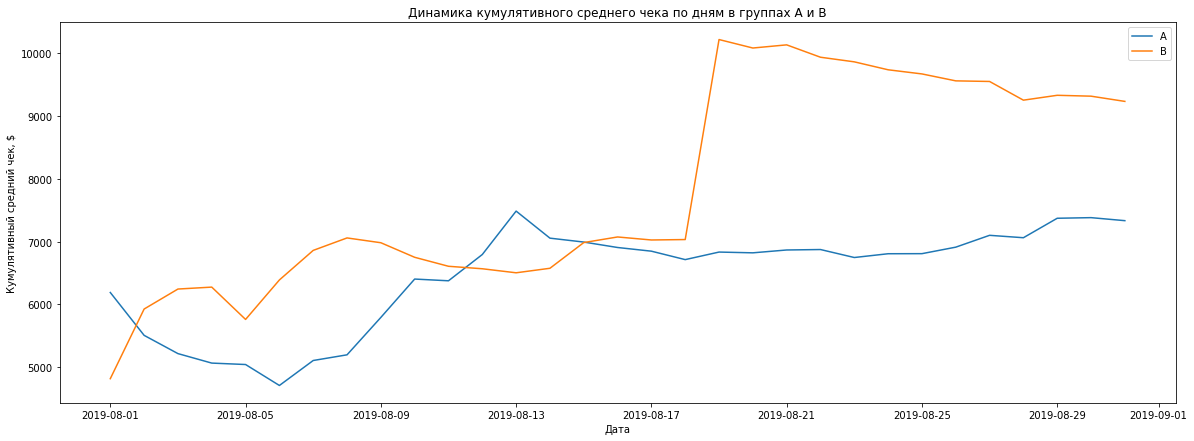

In [23]:
#построение графиков кумулятивного среднего чека по группам
plt.figure(figsize=(20, 7))
plt.title('Динамика кумулятивного среднего чека по дням в группах А и В')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек, $')
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'] / cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'] / cumulative_revenue_B['orders'], label='B')
plt.legend()
plt.show()

Средний чек в группе B выше, чем в группе А практически на протяжении всего периода наблюдения (за исключением первого дня и 13.08.2019). Средний чек относительно стабилизируется в группе А после 13.08.2019, в группе В наблюдается, аналогичный кумулятивной выручке, резкий рост среднего чека после 17.08.2019, что должно быть связано с появлением аномально крупных заказов.

### Относительное изменение кумулятивного среднего чека группы B к группе А

In [24]:
#объединение датафреймов с кумулятивными данными по группам
merged_cumulative_revenue = cumulative_revenue_A.merge(
    cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B']) 

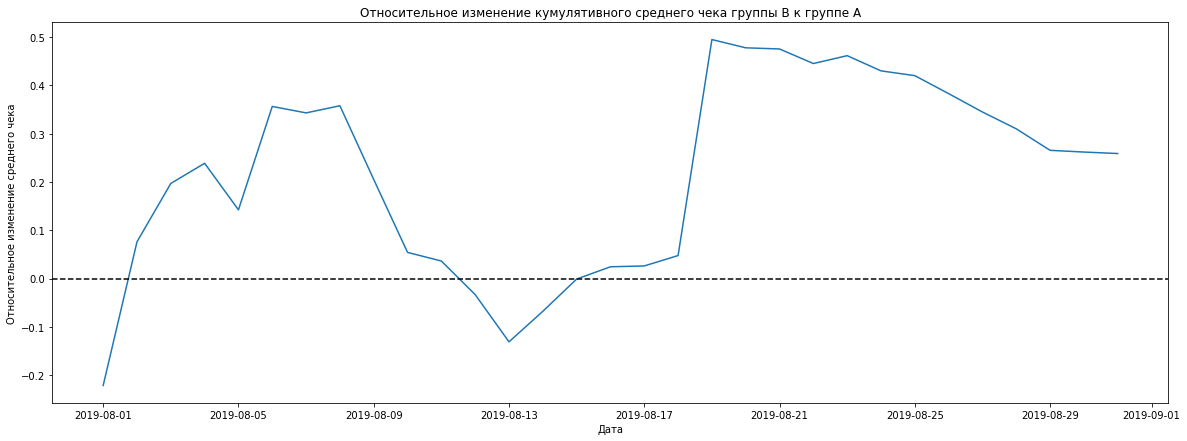

In [25]:
#построение графика относительного различия кумулятивного среднего чека группы B к А
plt.figure(figsize=(20, 7))
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе А')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднего чека')
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(
    merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Как было сказано ранее на протяжении практически всего периода наблюдения средний чек в группе В выше, чем в группе А. Отмечается два периода резкого роста среднего чека в группе В относительно группы А, в первой и второй половине исследования - там точно есть аномальные заказы!

### Кумулятивная конверсия по группам

In [26]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors'] #рассчет кумулятивной конверсии
cumulative_data_A = cumulative_data.query('group == "A"') #срез по группе А
cumulative_data_B = cumulative_data.query('group == "B"') #срез по группе B

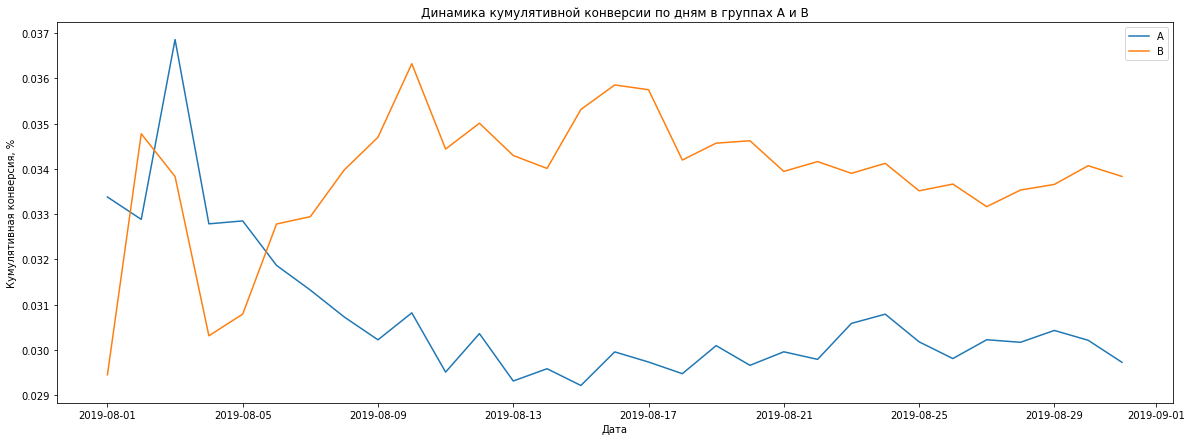

In [27]:
#построение графиков кумулятивной конверсии по группам
plt.figure(figsize=(20, 7))
plt.title('Динамика кумулятивной конверсии по дням в группах А и В')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия, %')
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')
plt.legend()
plt.show()

Показатели кумулятивной конверсии в начале наблюдения сильно колебались, после 9.08.2019 они относительно стабилизировались. Показатель кумулятивной конверсии в группе B зафиксировался на более высоком уровне, нежели показатель в группе А. 

### Относительное изменение кумулятивной конверсии группы B к группе A

In [28]:
#объединение датафреймов с кумулятивными данными по группам
merged_cumulative_conversions = cumulative_data_A[['date','conversion']].merge(
    cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

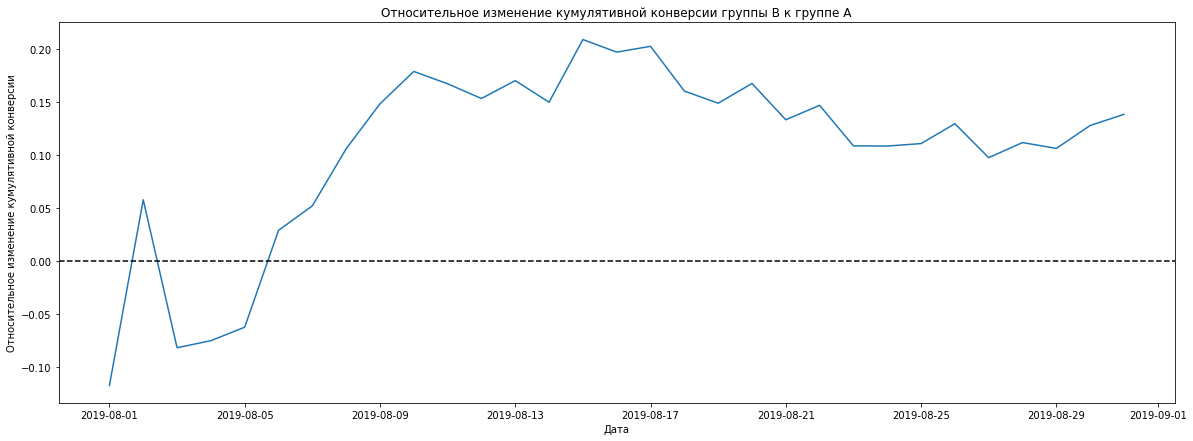

In [29]:
#построение графика относительного различия кумулятивной конверсии группы B к А
plt.figure(figsize=(20, 7))
plt.title('Относительное изменение кумулятивной конверсии группы B к группе А')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивной конверсии')
plt.plot(merged_cumulative_conversions['date'], 
         merged_cumulative_conversions['conversionB'] / merged_cumulative_conversions['conversionA'] -1)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Кумулятивная конверсия в группе В относительно группы А стабильно выше начиная с 6-7 августа. В конце периода наблюдения происходит некоторое снижение данного показателя и его стабилизация.

### Точечный график количество заказов, по пользователям

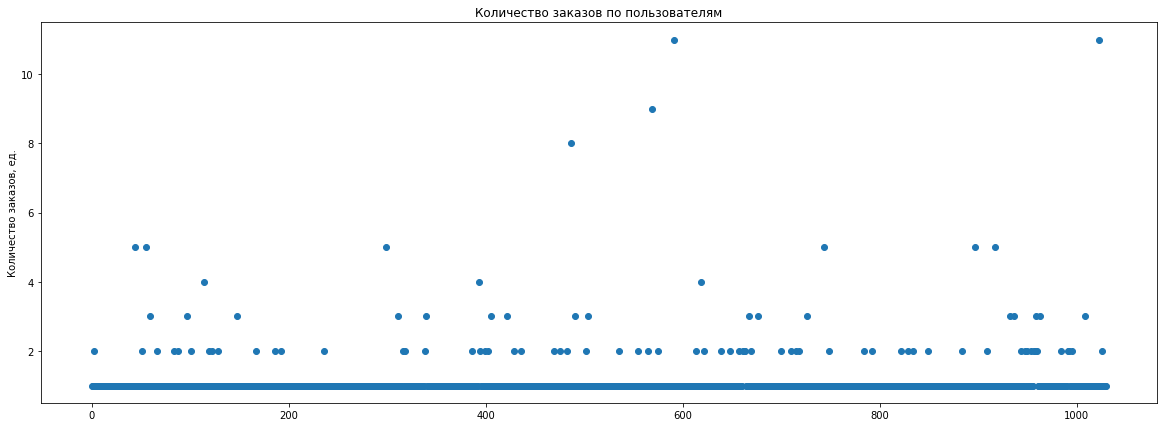

In [30]:
orders_by_users = orders.groupby('visitor_id', as_index=False).agg(
    {'transaction_id' : 'nunique'}) #группирровка заказов по пользователям
x_values = pd.Series(range(0, len(orders_by_users))) #значения для оси x
plt.figure(figsize=(20, 7))
plt.title('Количество заказов по пользователям')
plt.ylabel('Количество заказов, ед.')
plt.scatter(x_values, orders_by_users['transaction_id'])
plt.show()

Абсолютное большинство пользователей сделало 1-2 заказа, редкий пользователь сделал 3-4 заказа за раз, больше 4 почти никто - это явные аномалии. Но для окончательного выбора границы, по которой следует отделить аномальные заказы, лучше дополнительно воспользоваться 95-ым и 99-ым перцентилями.

### Выбор границы для определения аномальных пользователей

In [31]:
np.percentile(orders_by_users['transaction_id'], [95, 99])

array([2., 4.])

Не более 5% пользователей сделали более 2-х заказов и не более 1% более 4-х. В качестве границы для определения аномальных пользователей возьмем 2 заказа, т.е. отсеивать будем всех пользователей кто сделал более 2-х заказов.

### Точечный график стоимости заказов

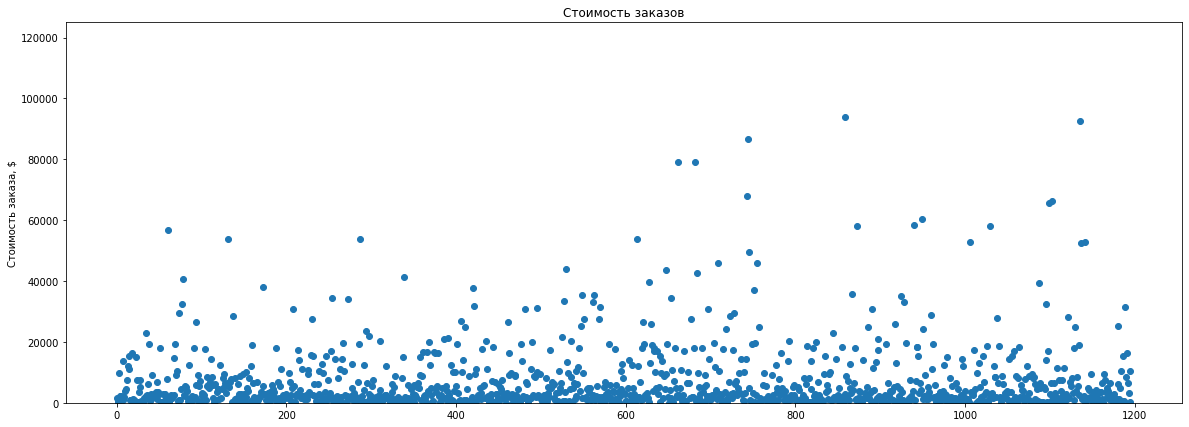

In [32]:
x_values = pd.Series(range(0, len(orders['revenue']))) #значения для оси x
plt.figure(figsize=(20, 7))
plt.ylim(0, 125000)
plt.title('Стоимость заказов')
plt.ylabel('Стоимость заказа, $')
plt.scatter(x_values, orders['revenue'])
plt.show()

Судя по графику стоимость большей части заказов не превышает 20000. Для определения границы аномальных заказов воспользуемся 95-ым и 99-ым перцентилем.

### Выбор границы для определения аномальных заказов

In [33]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% заказов стоили более 28000, и 1% заказов имел стоимость выше 58000. В качестве границы определяющей аномальные по стоимости заказы возьмём 28000.

### Оценка статистической значимости различий в конверсии между группами по "сырым данным"

Для оценки статистической значимости различий показателей в сравниваемых группах здесь и далее будем пользоваться непараметрическим тестом Уилкоксона-Манна-Уитни (U-критерий Манна-Уитни). Нулевая гипотеза будет гласить, что различий в средних значениях сравниваемых параметрах в разных группах нет, соответственно альтернативная гипотеза утверждает обратное - различия есть. Критический уровень статистической значимости примем за 5%.

Если я правильно понял, речь идёт о сравнении средней конверсии в группах, т.е. показатель кумулятивной конверсии, который мы находили ранее не подойдёт (хотя возможно я ошибаюсь).

In [34]:
conversion_per_day = orders.groupby(['date', 'group']).agg({'transaction_id' : 'nunique'}).merge(
    visitors, on=['date', 'group'], how='left') #объединение датафреймов с информацией о заказах и посещениях сайта

In [35]:
#расчет ежедневной конверсии
conversion_per_day['conversion'] = conversion_per_day['transaction_id'] / conversion_per_day['visitors'] 

In [36]:
conversion_per_day_A = conversion_per_day.query('group == "A"') #получение среза данных по группе А

In [37]:
conversion_per_day_B = conversion_per_day.query('group == "B"') #получение среза данных по группе B

In [38]:
alpha = .05 #критический уровень статистической значимости
p_value = st.mannwhitneyu(conversion_per_day_A['conversion'], conversion_per_day_B['conversion'])[1] #U-критерий Манна-Уитни
print('Средняя конверсия в группе А:', '{0:.3f}'.format(conversion_per_day_A['conversion'].mean()))
print('Средняя конверсия в группе B:', '{0:.3f}'.format(conversion_per_day_B['conversion'].mean()))
print('Относительный прирост конверсии в группе В:', 
      '{0:.3f}'.format(conversion_per_day_B['conversion'].mean() / conversion_per_day_A['conversion'].mean() - 1))
print('p-value:', '{0:.3f}'.format(p_value))

if p_value > alpha:
    print('Нельзя отвергнуть нулевую гипотезу, разница показателей статистически незначима!')
else:
    print('Нулевая гипотеза отвергнута, разница показателей статистически значима!')

Средняя конверсия в группе А: 0.031
Средняя конверсия в группе B: 0.035
Относительный прирост конверсии в группе В: 0.150
p-value: 0.086
Нельзя отвергнуть нулевую гипотезу, разница показателей статистически незначима!


Относительный прирост конверсии значительный, но по результатам теста Уилкоксона-Манна-Уитни, разница между показателями средней конверсии в группах А и В статистической значимости не имеет.

In [39]:
#получение таблицы с количеством посещений в день в группе А
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

#получение таблицы с кумулятивным количеством посещений по дням в группе А
visitors_A_сummulative = visitors_A_daily.apply(lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}),axis=1)
visitors_A_сummulative.columns = ['date', 'visitors_A_сummulative']

#тоже самое для группы В
visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']
visitors_B_сummulative = visitors_B_daily.apply(lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}),axis=1)
visitors_B_сummulative.columns = ['date', 'visitors_B_сummulative']

#получение таблицы с ежедневным количеством заказов и выручкой для группы А
orders_A_daily = orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']].groupby(
    'date', as_index=False).agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

#получение кумулятивного количества заказов и выручки
orders_A_cummulative = orders_A_daily.apply(lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}), axis=1).sort_values(by=['date'])
orders_A_cummulative.columns = ['date', 'orders_A_cummulative', 'revenue_cummulative_A']

#тоже самое для группы В
orders_B_daily = orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']].groupby(
    'date', as_index=False).agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

orders_B_cummulative = orders_B_daily.apply(lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}), axis=1).sort_values(by=['date'])
orders_B_cummulative.columns = ['date', 'orders_B_cummulative', 'revenue_cummulative_B']

#объединение, полученных таблиц
data = orders_A_daily.merge(orders_B_daily, left_on='date', right_on='date', how='left').merge(
    orders_A_cummulative, left_on='date', right_on='date', how='left').merge(
    orders_B_cummulative, left_on='date', right_on='date', how='left').merge(
    visitors_A_daily, left_on='date', right_on='date', how='left').merge(
    visitors_B_daily, left_on='date', right_on='date', how='left').merge(
    visitors_A_сummulative, left_on='date', right_on='date', how='left').merge(
    visitors_B_сummulative, left_on='date', right_on='date', how='left')

data.head()


,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_A_cummulative,revenue_cummulative_A,orders_B_cummulative,revenue_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_A_сummulative,visitors_B_сummulative
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [40]:
#создание таблиц с количеством заказов для пользователей, которые сделали хотя бы один заказ
orders_by_users_A = orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False).agg(
    {'transaction_id': pd.Series.nunique})
orders_by_users_A.columns = ['user_id', 'orders']

orders_by_users_B = orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False).agg(
    {'transaction_id': pd.Series.nunique})

orders_by_users_B.columns = ['user_id', 'orders'] 

In [41]:
#создание таблиц в которым пользователям соответствует количество заказов, в т.ч. 0 для не сделавших заказ
sample_A = pd.concat([orders_by_users_A['orders'], pd.Series(0, index=np.arange(
    data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])), name='orders')], axis=0)

sample_B = pd.concat([orders_by_users_B['orders'], pd.Series(0, index=np.arange(
    data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])), name='orders')], axis=0)

In [42]:
alpha = .05 #критический уровень статистической значимости
p_value = st.mannwhitneyu(sample_A, sample_B)[1] #U-критерий Манна-Уитни
print('Средняя конверсия в группе А:', '{0:.3f}'.format(sample_A.mean()))
print('Средняя конверсия в группе B:', '{0:.3f}'.format( sample_B.mean()))
print('Относительный прирост конверсии в группе В:', 
      '{0:.3f}'.format(sample_B.mean() / sample_A.mean() - 1))
print('p-value:', '{0:.3f}'.format(p_value))

if p_value > alpha:
    print('Нельзя отвергнуть нулевую гипотезу, разница показателей статистически незначима!')
else:
    print('Нулевая гипотеза отвергнута, разница показателей статистически значима!')

Средняя конверсия в группе А: 0.030
Средняя конверсия в группе B: 0.034
Относительный прирост конверсии в группе В: 0.138
p-value: 0.017
Нулевая гипотеза отвергнута, разница показателей статистически значима!


Разница в показателях при оценке по "сырым данным" оказалась статистически значимой. В группе В конверсия выше.

### Оценка статистической значимости различий в среднем чеке между группами по "сырым данным"

In [43]:
alpha = .05 #критический уровень статистической значимости
p_value = st.mannwhitneyu(
    orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'])[1] #U-критерий Манна-Уитни
print('Средний чек в группе А:', '{0:.2f}'.format(orders.query('group == "A"')['revenue'].mean()))
print('Средний чек в группе B:', '{0:.2f}'.format(orders.query('group == "B"')['revenue'].mean()))
print('Относительный прирост среднего чека в группе В:', '{0:.3f}'.format(
    orders.query('group == "B"')['revenue'].mean() / orders.query('group == "A"')['revenue'].mean() - 1))
print('p-value:', '{0:.3f}'.format(p_value))

if p_value > alpha:
    print('Нельзя отвергнуть нулевую гипотезу, разница показателей статистически незначима!')
else:
    print('Нулевая гипотеза отвергнута, разница показателей статистически значима!')

Средний чек в группе А: 7333.58
Средний чек в группе B: 9230.88
Относительный прирост среднего чека в группе В: 0.259
p-value: 0.729
Нельзя отвергнуть нулевую гипотезу, разница показателей статистически незначима!


Мы наблюдаем высокий относительный прирост среднего чека, но статистической значимости разницы в средних чеках также не выявлено.

### Оценка статистической значимости различий в конверсии между группами по "очищенным данным"

Оценим значимость статистических различий в средней конверсии и среднем чеке в группах А и В в соответсвии с приведённым выше алгоритмом, но используя "очищенные" от аномалий данные.

In [50]:
#получение таблицы с аномальными пользователями
users_with_many_orders = pd.concat([orders_by_users_A[orders_by_users_A['orders'] > 2]['user_id'], 
                                    orders_by_users_B[orders_by_users_B['orders'] > 2]['user_id']], axis=0)
users_with_expensive_orders = orders[orders['revenue'] > 28000]['transaction_id']
abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0).drop_duplicates().sort_values()

In [51]:
#фильтрация
sample_A_filtered = pd.concat([orders_by_users_A[np.logical_not(orders_by_users_A['user_id'].isin(
    abnormal_users))]['orders'], pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - len(
    orders_by_users_A['orders'])), name='orders')], axis=0)

sample_B_filtered = pd.concat([orders_by_users_B[np.logical_not(orders_by_users_B['user_id'].isin(
    abnormal_users))]['orders'], pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - len(
    orders_by_users_B['orders'])), name='orders')], axis=0) 

In [52]:
alpha = .05 #критический уровень статистической значимости
p_value = st.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1] #U-критерий Манна-Уитни
print('Средняя конверсия в группе А:', '{0:.3f}'.format(sample_A_filtered.mean()))
print('Средняя конверсия в группе B:', '{0:.3f}'.format(sample_B_filtered.mean()))
print('Относительный прирост конверсии в группе В:', 
      '{0:.3f}'.format(sample_B_filtered.mean() / sample_A_filtered.mean() - 1))
print('p-value:', '{0:.3f}'.format(p_value))

if p_value > alpha:
    print('Нельзя отвергнуть нулевую гипотезу, разница показателей статистически незначима!')
else:
    print('Нулевая гипотеза отвергнута, разница показателей статистически значима!')

Средняя конверсия в группе А: 0.027
Средняя конверсия в группе B: 0.031
Относительный прирост конверсии в группе В: 0.170
p-value: 0.012
Нулевая гипотеза отвергнута, разница показателей статистически значима!


При оценке статистической значимости различий средней конверсии по "очищенным" данным, относительный прирост средней конверсии ещё выше, чем по "сырым" данным, и при этом разница между показателями статистически значима. Т.е. средняя конверсии в группе B действительно выше.

### Оценка статистической значимости различий в среднем чеке между группами по "очищенным данным"

In [53]:
alpha = .05 #критический уровень статистической значимости
p_value = st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', np.logical_not(
    orders['visitor_id'].isin(abnormal_users)))]['revenue'], orders[
    np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])[1] #U-критерий Манна-Уитни
print('Средний чек в группе А:', '{0:.2f}'.format(orders[np.logical_and(orders['group'] == 'A', np.logical_not(
    orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()))
print('Средний чек в группе B:', '{0:.2f}'.format(orders[np.logical_and(orders['group'] == 'B', np.logical_not(
    orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()))
print('Относительный прирост среднего чека в группе В:', '{0:.3f}'.format(orders[np.logical_and(
    orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(
        abnormal_users)))]['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A', np.logical_not(
    orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean() - 1))
print('p-value:', '{0:.3f}'.format(p_value))

if p_value > alpha:
    print('Нельзя отвергнуть нулевую гипотезу, разница показателей статистически незначима!')
else:
    print('Нулевая гипотеза отвергнута, разница показателей статистически значима!')

Средний чек в группе А: 7483.45
Средний чек в группе B: 9235.59
Относительный прирост среднего чека в группе В: 0.234
p-value: 0.661
Нельзя отвергнуть нулевую гипотезу, разница показателей статистически незначима!


При сравнении средних чеков по отфильтрованным данным статиcтической значимости разницы показателей нет.

### Принятие решения по результатам теста

Для принятия решения по результатам теста визуализируем относительное изменение кумулятивной конверсии и среднего чека с учетом отфильтрованных данных.

In [54]:
orders_filtered = orders[~(orders['visitor_id'].isin(abnormal_users))]
orders_aggregated_filtered = dates_groups.apply(
    lambda x: orders_filtered[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), 
    axis=1).sort_values(by=['date','group']) #получение агрегированных кумулятивных данных о заказах по дням

In [55]:
cumulative_data_filtered = orders_aggregated_filtered.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']) #объединение таблиц с агрегированными данными
cumulative_data_filtered.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors'] 
#переименование столбцов в полученной таблице

In [56]:
cumulative_revenue_A_filtered = cumulative_data_filtered[cumulative_data_filtered['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_B_filtered = cumulative_data_filtered[cumulative_data_filtered['group']=='B'][['date','revenue', 'orders']]
#получение таблиц с кумулятивным количеством заказов и кумулятивной выручкой в группах А и В

In [57]:
#объединение датафреймов с кумулятивными данными по группам
merged_cumulative_revenue_filtered = cumulative_revenue_A_filtered.merge(
    cumulative_revenue_B_filtered, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

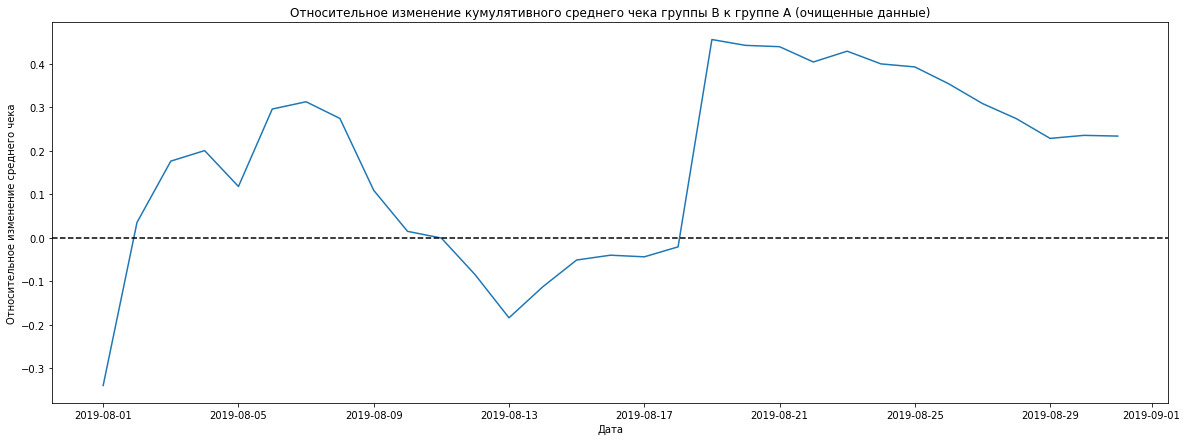

In [58]:
#построение графика относительного различия кумулятивного среднего чека группы B к А
plt.figure(figsize=(20, 7))
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе А (очищенные данные)')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднего чека')
plt.plot(merged_cumulative_revenue_filtered['date'], (
    merged_cumulative_revenue_filtered['revenueB']/merged_cumulative_revenue_filtered['ordersB'])/(
    merged_cumulative_revenue_filtered['revenueA']/merged_cumulative_revenue_filtered['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

По "очищенным" данным видно что кумулятивный средний чек в группе В в среднем выше, но к настоящему моменту стабилизировался и даже показывает некоторое снижение, учитывая что статистической разницы в среднем чеке нет, то вряд ли она уже появиться. 

In [59]:
cumulative_data_filtered['conversion'] = cumulative_data_filtered['orders'] / cumulative_data_filtered['visitors'] #рассчет кумулятивной конверсии
cumulative_data_filtered_A = cumulative_data_filtered.query('group == "A"') #срез по группе А
cumulative_data_filtered_B = cumulative_data_filtered.query('group == "B"') #срез по группе B

In [60]:
#объединение датафреймов с кумулятивными данными по группам
merged_cumulative_conversions_filtered = cumulative_data_filtered_A[['date','conversion']].merge(
    cumulative_data_filtered_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

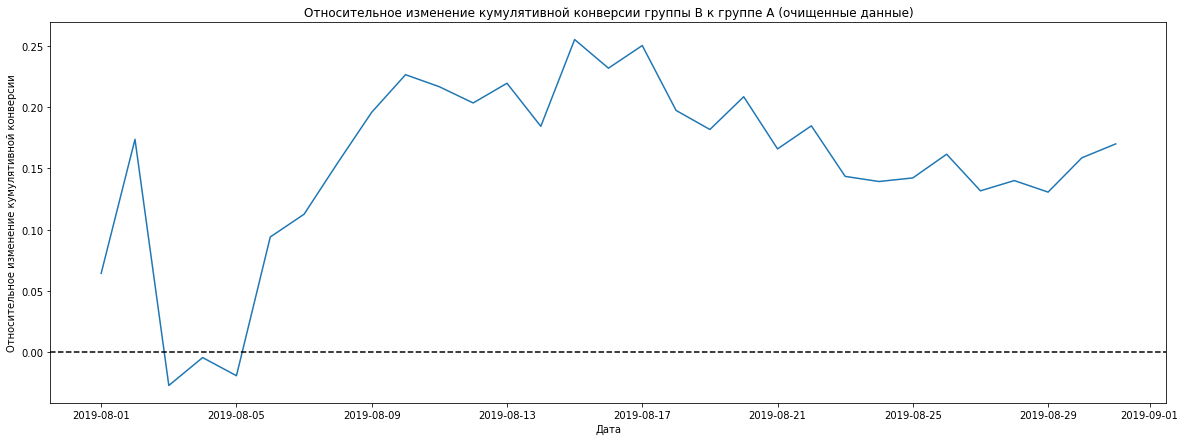

In [61]:
#построение графика относительного различия кумулятивной конверсии группы B к А
plt.figure(figsize=(20, 7))
plt.title('Относительное изменение кумулятивной конверсии группы B к группе А (очищенные данные)')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивной конверсии')
plt.plot(merged_cumulative_conversions_filtered['date'], 
         merged_cumulative_conversions_filtered['conversionB'] / merged_cumulative_conversions_filtered['conversionA'] -1)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Показатель кумулятивной конверсии в группе В, как и в случае с использованием "сырых" данных, существенно превысил конверсию в группе А ещё в начале исследования.

Учитывая, результаты теста Уилкоксона-Манна-Уитни на "очищенных" данных, значения средней и кумулятивной конверсии, можно сделать вывод, что проверяемое нами вмешательство приводит к довольно быстрому увеличению конверсии, и не приводит к увеличению среднего чека. Можно остановить исследование и сделать вывод, что тестируемое вмешательство приведёт к увеличению прибыли, т.к. при том же среднем чеке вырастет конверсия.

## Общий вывод

В ходе выполненного проекта, были проведены:
1. Приоритизация выдвинутых гипотез с использованием фреймворков ICE и RICE:
- при использовании фреймворка ICE самой приоритетной выступила гипотеза №8;
- при использовании фреймворка RICE наиболее приоритетная гипотеза - гипотеза №7;
- указанные различия связаны со значительно более высоким показателем охвата у гипотезы №7.
2. Анализ А/В-теста:
- кумулятивная выручка растёт в обоих группах на протяжении всего теста, и в среднем выше в группе В, однако имеются резкие колебания кумулятивной выручки, что указывает на наличие аномалий;
- кумулятивный средний чек в среднем выше в группе В, но в его динамике отмечены аналогичные резкие колебания, также свидетельствующие о наличии аномалий;
- кумулятивная конверсия в группе В быстро обгоняет аналогичный показатель в группе А, наблюдается относительная стабилизация показателе в каждой группе;
- с использованием точечных графиков и 95-ого, 99-ого перцентилей определены границы для отсечения аномальных пользователей: пользователи совершившие более 2-х заказов и заказы стоимостью более 28000;
- при оценке статистической значимости в показателях средней конверсии и среднего чека по группам на "сырых" данных с использованием U-критерия Манна-Уитни, получено отсутствие статистически значимой разницы в различиях по обоим показателям;
- при аналогичной оценке на "очищенных" от аномалий данных, выявлена статистически значимая разница в показателе средней конверсии (в группе В средняя конверсия достоверно выше, относительный прирост - 0,184), и не выявлено статистически значимых различий в показателях среднего чека;
- принято решение остановить тест с фиксацией следующего результата: тестируемое вмешательство приводит к росту конверсии, но не приводит к увеличению среднего чека.